In [3]:
import random
import datetime
import numpy as np
import h5py
from skimage.filters import threshold_otsu
from skimage import io
from scipy import interpolate
from matplotlib import pyplot as plt
import math
import tifffile
import os
import sys
import shutil
from skimage.draw import polygon as ski_polygon
import json

import openslide
from preprocessing.datamodel import SlideManager
from preprocessing.processing import split_negative_slide, split_positive_slide, create_tumor_mask, rgb2gray
from preprocessing.util import TileMap

%matplotlib inline

In [4]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from sklearn.metrics import roc_curve, auc
from scipy.special import softmax #e to the x and divide by sum
import matplotlib.pyplot as plt
import time
from datetime import date
import os
import sys
import copy
from tqdm import tqdm
import shutil
import calculate_performance as calc

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.6.0
Torchvision Version:  0.7.0


## Define parameters

In [7]:
DIR = ''

mgr = SlideManager(cam16_dir=DIR)

slides_met = mgr.met_slides

N_met = len(slides_met)

slides_negative = mgr.negative_slides

N_negative = len(slides_negative)

level = 0

tile_size = 256 #must be the same as used for training

poi = 0.50 #must use the same poi we used to seperate tisse from background

overlap = tile_size // 2 #increasing overlap will put patches closer together

input_size = tile_size

n_folds = 15

In [8]:
data_dir = "./patches/test/"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "resnet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Plot ROC for all folds

<IPython.core.display.Javascript object>


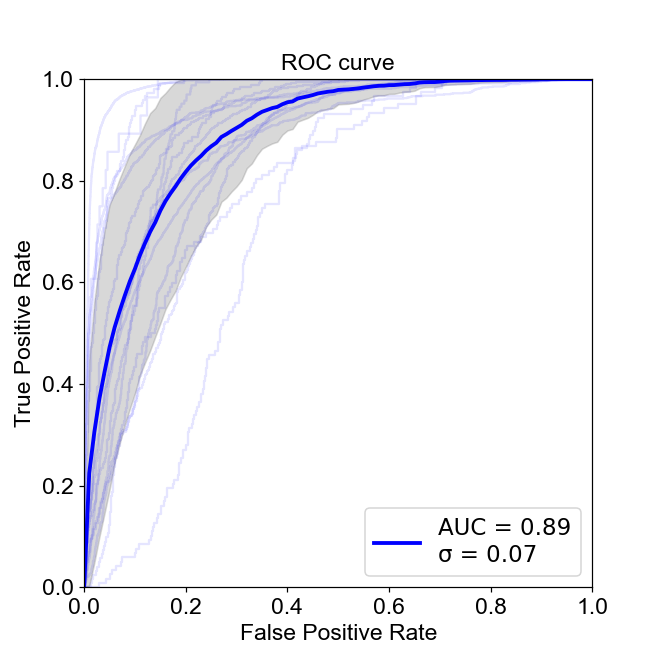

In [10]:
prediction_folder_path = 'predictions//Kfold//ROC//'

%matplotlib notebook
plt.figure(figsize = (6,6))
ax = plt.gca()
ax.set_aspect(1)
lw = 3
font_size = 15

tprs = []
base_fpr = np.linspace(0, 1, 101)

auc_fold = []
fold = 0
for fold in range(n_folds):
    fpr = np.load(prediction_folder_path + str(fold) + '_fpr.npy')
    tpr = np.load(prediction_folder_path + str(fold) + '_tpr.npy')
    auc_fold.append(auc(fpr, tpr))

    plt.plot(fpr, tpr, 'b', alpha=0.10)
    
    tpr = np.interp(base_fpr, fpr, tpr)
    tpr[0] = 0.0
    tprs.append(tpr)
    
    
tprs = np.array(tprs)
mean_tprs = tprs.mean(axis=0)
roc_auc = auc(base_fpr,mean_tprs)
auc_std = np.std(auc_fold)
std = tprs.std(axis=0)

tprs_upper = np.minimum(mean_tprs + std, 1)
tprs_lower = mean_tprs - std

plt.plot(base_fpr, mean_tprs, 'b', lw = '2.5', label = 'AUC = %0.2f' % roc_auc + '\n' + '\u03C3 = ' + '%0.2f' % auc_std)#'Average ROC')# 
plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.3)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xticks(fontsize = font_size, family = 'Arial')
plt.yticks(fontsize = font_size, family = 'Arial')
plt.xlabel('False Positive Rate', fontsize = font_size, family = 'Arial')
plt.ylabel('True Positive Rate', fontsize = font_size, family = 'Arial')
plt.title('ROC curve', fontsize = font_size, family = 'Arial')
plt.legend(loc="lower right", fontsize = font_size)
plt.show()
plt.savefig(prediction_folder_path + 'ROC_all.tiff',dpi = 300)

## Measure sensitivity and specificity

In [9]:
desired_sensitivity = 0.90
# Interpolate average specificity for desired sensitivity
specificity = 1 - np.interp(desired_sensitivity, mean_tprs, base_fpr)
print('sensitivity = ' + str(desired_sensitivity))
print('specificity = ' + str(specificity))

sensitivity = 0.9
specificity = 0.7071073030157365
